# Demonstration of VAE-based Models

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

from data_enricher.models.vae_models import *
from data_enricher.utils.vae_utils import *
from data_enricher.comparison import *


Load Data

In [109]:
# Load data as dataframe
df = pd.read_csv('data/europe.csv')
countries = df.columns.tolist()
data = torch.tensor(df.values, dtype=torch.float32)
# randomly split data into train and test
np.random.seed(2112)
train_idx = np.random.choice(data.shape[0], int(0.8 * data.shape[0]), replace=False)
test_idx = np.setdiff1d(np.arange(data.shape[0]), train_idx)
train_data = data[train_idx]
test_data = data[test_idx]

Initialize Model

In [157]:
model = VAE(input_dim=data.shape[1], latent_dim=10, num_hidden_layers=2, num_neurons=500)

Train Model

In [158]:
model.train(x=train_data, beta=0.5, mc_samples=2, learning_rate=1e-4, epochs=200, batch_size=32)

Iteration: 100/10400 -- ELBO=-1.37e+01 / RLL=-8.86e+00 / KL=4.80e+00
Iteration: 200/10400 -- ELBO=-9.73e+00 / RLL=-5.20e+00 / KL=4.53e+00
Iteration: 300/10400 -- ELBO=-9.43e+00 / RLL=-5.17e+00 / KL=4.26e+00
Iteration: 400/10400 -- ELBO=-9.91e+00 / RLL=-5.16e+00 / KL=4.74e+00
Iteration: 500/10400 -- ELBO=-1.08e+01 / RLL=-5.71e+00 / KL=5.08e+00
Iteration: 600/10400 -- ELBO=-1.06e+01 / RLL=-5.84e+00 / KL=4.75e+00
Iteration: 700/10400 -- ELBO=-9.13e+00 / RLL=-4.00e+00 / KL=5.12e+00
Iteration: 800/10400 -- ELBO=-1.03e+01 / RLL=-5.29e+00 / KL=4.98e+00
Iteration: 900/10400 -- ELBO=-1.29e+01 / RLL=-8.17e+00 / KL=4.70e+00
Iteration: 1000/10400 -- ELBO=-9.52e+00 / RLL=-4.50e+00 / KL=5.02e+00
Iteration: 1100/10400 -- ELBO=-8.96e+00 / RLL=-4.09e+00 / KL=4.87e+00
Iteration: 1200/10400 -- ELBO=-9.47e+00 / RLL=-4.60e+00 / KL=4.87e+00
Iteration: 1300/10400 -- ELBO=-9.23e+00 / RLL=-4.21e+00 / KL=5.02e+00
Iteration: 1400/10400 -- ELBO=-8.68e+00 / RLL=-3.82e+00 / KL=4.86e+00
Iteration: 1500/10400 -- ELBO

Take Samples for Visualization

In [159]:
num_samples = train_data.shape[0]

sample_param_dict = model.sample(num_samples_prior=num_samples, num_samples_likelihood=3)

samples = sample_param_dict["samples"].flatten(end_dim=1).detach().numpy()

train_data_list = [['Training data']+x for x in train_data.tolist()]
sample_list = [['Generated data']+x for x in samples.tolist()]
pair_df = pd.DataFrame(train_data_list+sample_list,columns=['type']+countries)

pair_df_filtered = pair_df.loc[:, ['type', 'NO', 'FR', 'IT']]

country_mask = [country in ['NO', 'FR', 'IT'] for country in countries]


Compare Samples Visually

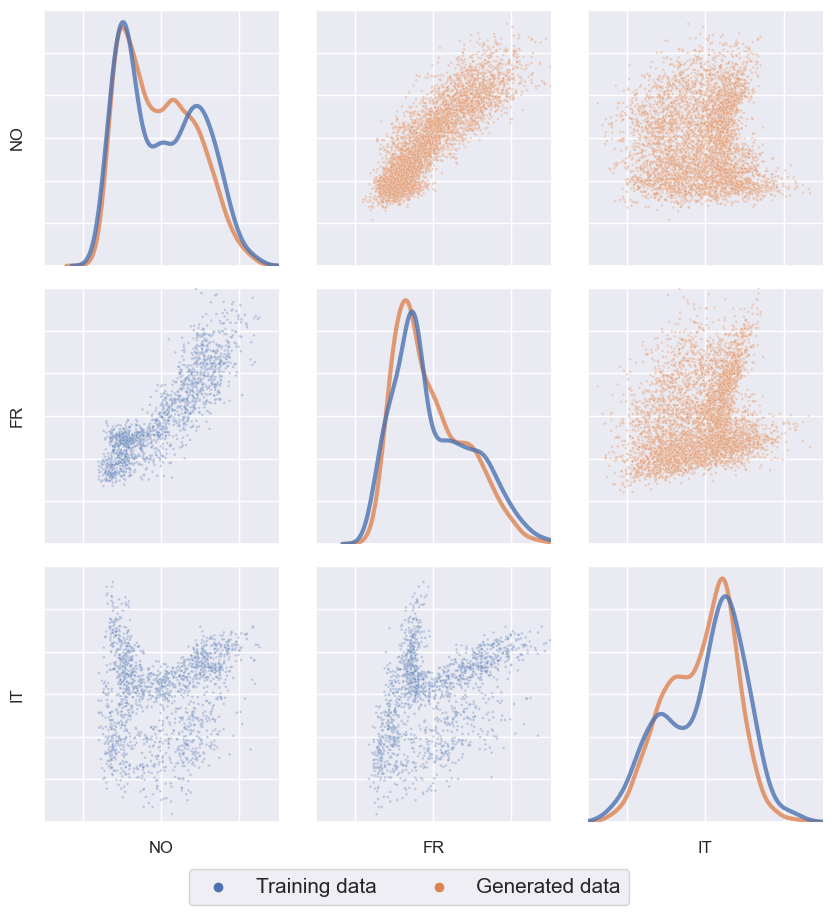

In [160]:
g = sns.PairGrid(pair_df_filtered, diag_sharey=False, hue="type", height=3, aspect=1.0)
g.map_diag(sns.kdeplot, common_norm=False, lw=3, alpha=0.8)

g.data = pair_df_filtered[pair_df_filtered['type'] != 'Generated data']
g.map_lower(sns.scatterplot, s=15, alpha=0.3, edgecolors='face', linewidths=0.0, marker='.')

g.data = pair_df_filtered[pair_df_filtered['type'] == 'Generated data']
g.map_upper(sns.scatterplot, s=15, alpha=0.3, edgecolors='face', linewidths=0.0, marker='.')

lims = 3.0
g.set(xlim=[-lims,lims], ylim=[-lims,lims])
g.set(xticklabels=[], yticklabels=[])

g.add_legend(title='', ncol=2, bbox_to_anchor=(0.525, -0.0), frameon=True, fontsize=15)
plt.show()

Sample and Model Comparison Scores

In [161]:
sample_param_dict = model.sample(num_samples_prior=num_samples, num_samples_likelihood=1)

samples = sample_param_dict["samples"].flatten(end_dim=1).detach()

sample_test = "energy"
model_scores, base_scores = sample_comparison(model_samples=samples, train_samples=train_data, test_samples=test_data, test=sample_test, subsample_ratio=0.4, mc_runs=1000)

In [162]:
model_test = "ks"
model_score = model_comparison(model_scores=model_scores, base_scores=base_scores, test=model_test)

[]

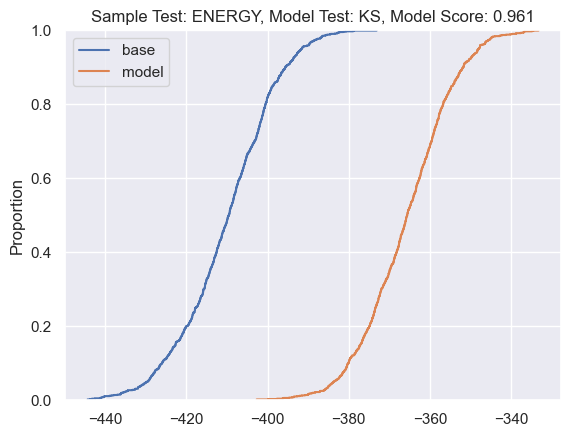

In [163]:
sns.ecdfplot(base_scores, label='base')
sns.ecdfplot(model_scores, label='model')
plt.legend()
plt.title(f"Sample Test: {sample_test.upper()}, Model Test: {model_test.upper()}, Model Score: {model_score:.3f}")
plt.plot()

Missing Value Imputation

In [164]:
# Create missingness
np.random.seed(2023)
missing_data = test_data.clone()
num_test_data, num_features = missing_data.shape
missing_data_idx = np.random.choice(num_test_data*num_features, int(0.1*num_test_data*num_features), replace=False)
missing_data[missing_data_idx//num_features, missing_data_idx%num_features] = np.nan
num_missing_data = torch.isnan(missing_data).sum().item()

In [165]:
imputed_data = model.impute(missing_data.clone(), num_steps=1000)

In [166]:
((imputed_data - test_data)**2).sum() / num_missing_data

tensor(0.2013)